In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   reggio_di_calabria
   2   pordenone
   3   firenze
   4   matera
   5   foggia
   6   forli
   7   grosseto
   8   rieti
   9   brindisi
   10   ferrara
   11   ancona
   12   trento
   13   cuneo
   14   reggio_nell_emilia
   15   bari
   16   sassari
   17   lecco
   18   siena
   19   pesaro
   20   mantova
   21   modena
   22   piacenza
   23   biella
   24   vercelli
   25   catania
   26   rovigo
   27   nuoro
   28   roma
   29   rimini
   30   asti
   31   enna
   32   siracusa
   33   pisa
   34   oristano
   35   ascoli_piceno
   36   prato
   37   alessandria
   38   torino
   39   isernia
   40   sondrio
   41   bergamo
   42   avellino
   43   l_aquila
   44   palermo
   45   teramo
   46   lucca
   47   latina
   48   varese
   49   verbania
   50   perugia
   51   la_spezia
   52   catanzaro
   53   chieti
   54   bologna
   55   lecce
   56   ravenna
   57   fermo
   58   caserta
   59   c

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 reggio_di_calabria
2 pordenone
3 firenze
4 matera
5 foggia
6 forli
7 grosseto
8 rieti
9 brindisi
10 ferrara
11 ancona
12 trento
13 cuneo
14 reggio_nell_emilia
15 bari
16 sassari
17 lecco
18 siena
19 pesaro
20 mantova
21 modena
22 piacenza
23 biella
24 vercelli
25 catania
26 rovigo
27 nuoro
28 roma
29 rimini
30 asti
31 enna
32 siracusa
33 pisa
34 oristano
35 ascoli_piceno
36 prato
37 alessandria
38 torino
39 sondrio
40 bergamo
41 avellino
42 l_aquila
43 palermo
44 teramo
45 lucca
46 latina
47 varese
48 verbania
49 perugia
50 la_spezia
51 catanzaro
52 chieti
53 bologna
54 lecce
55 ravenna
56 fermo
57 caserta
58 macerata
59 cagliari
60 milano
61 brescia
62 ragusa
63 lodi
64 terni
65 campobasso
66 vicenza
67 trieste
68 verona
69 imperia
70 caltanissetta
71 venezia
72 arezzo
73 genova
74 massa
75 frosinone
76 treviso
77 bolzano
78 napoli
79 como
80 gorizia
81 benevento
82 novara
83 pavia
84 pescara
85 vibo_valentia
86 bat
87 taranto
88 livorno
89 pistoia
90 belluno
91 viterbo
92 savona
93

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35682  0.02538 
    Test set average RMSE:  0.95350  0.09741 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33845
                       R2:  0.94758


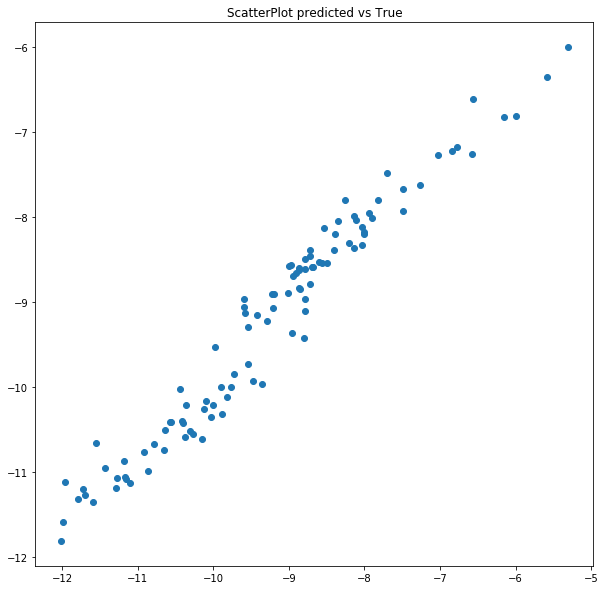

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05545
Feature:               commutersdensity, Score: 0.03998
Feature:                         depriv, Score: 0.05804
Feature:                            lat, Score: 0.66788
Feature:                 Ratio0200ver65, Score: 0.09087
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00627
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00712
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00988
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02197
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02087
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01462
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00704


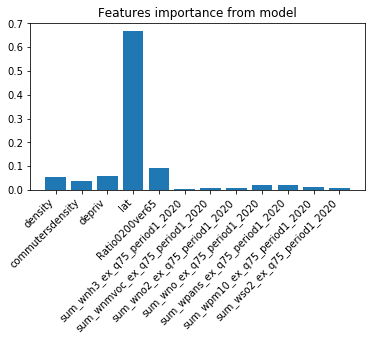

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.10385
Feature:               commutersdensity, Score: 0.07217
Feature:                         depriv, Score: 0.13906
Feature:                            lat, Score: 3.29575
Feature:                 Ratio0200ver65, Score: 0.21107
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01677
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01209
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.02112
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.07929
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.08211
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02999
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02517


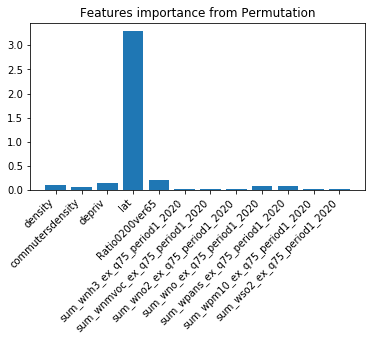

<Figure size 720x720 with 0 Axes>

((0.3568206171142239, 0.02538232484813024),
 (0.9535018622951184, 0.09740928987342333),
 0.33844613522809575,
 {'density': 0.025401112710631918,
  'commutersdensity': 0.017651657154412127,
  'depriv': 0.034012136598458316,
  'lat': 0.8061181987368728,
  'Ratio0200ver65': 0.05162534082883058,
  'sum_wnh3_ex_q75_period1_2020': 0.004100990887486946,
  'sum_wnmvoc_ex_q75_period1_2020': 0.0029576698090641265,
  'sum_wno2_ex_q75_period1_2020': 0.005165327045193835,
  'sum_wno_ex_q75_period1_2020': 0.01939267399298791,
  'sum_wpans_ex_q75_period1_2020': 0.02008417905981618,
  'sum_wpm10_ex_q75_period1_2020': 0.007335080192926827,
  'sum_wso2_ex_q75_period1_2020': 0.006155632983318377})

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.11454578645083448
2  of  1200 MSE:  0.11122678896708929
3  of  1200 MSE:  0.18089797576345953
4  of  1200 MSE:  0.28048064766166936
5  of  1200 MSE:  0.4272759028040201
6  of  1200 MSE:  0.5623642665863412
7  of  1200 MSE:  0.608768213845983
8  of  1200 MSE:  0.7167547130087223
9  of  1200 MSE:  0.18048568502753837
10  of  1200 MSE:  0.2431935434950318
11  of  1200 MSE:  0.2073874505151681
12  of  1200 MSE:  0.29930161292266744
13  of  1200 MSE:  0.4272759028040201
14  of  1200 MSE:  0.5623642665863412
15  of  1200 MSE:  0.608768213845983
16  of  1200 MSE:  0.7167547130087223
17  of  1200 MSE:  0.3205304196506719
18  of  1200 MSE:  0.4132659526325306
19  of  1200 MSE:  0.3443898804440902
20  of  1200 MSE:  0.4392018803797321
21  of  1200 MSE:  0.4272759028040201
22  of  1200 MSE:  0.5623642665863412
23  of  1200 MSE:  0.608768213845983
24  of  1200 MSE:  0.7167547130087223
25  of  1200 MSE:  0.4327793364008587
26  of  1200 MSE:  0.5279252867214203
27  of  1200 MSE: 

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}
Training set average RMSE:  0.34390  0.02126 
    Test set average RMSE:  0.95901  0.09543 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33049
                       R2:  0.95002


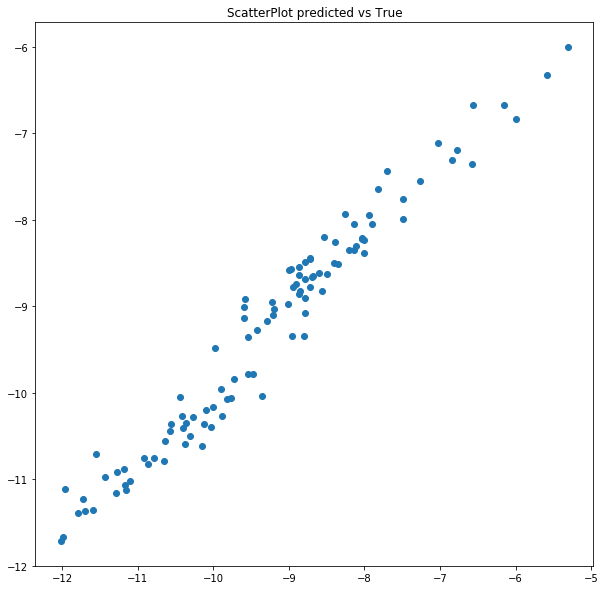

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05895
Feature:               commutersdensity, Score: 0.17302
Feature:                         depriv, Score: 0.09676
Feature:                            lat, Score: 0.27583
Feature:                 Ratio0200ver65, Score: 0.07695
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.05957
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.05713
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.09691
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01622
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02278
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04543
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02045


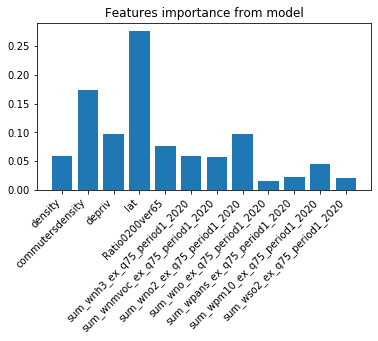

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.11313
Feature:               commutersdensity, Score: 0.05812
Feature:                         depriv, Score: 0.16027
Feature:                            lat, Score: 3.23862
Feature:                 Ratio0200ver65, Score: 0.23536
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01286
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01243
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.02204
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.08026
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05172
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02057
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01876


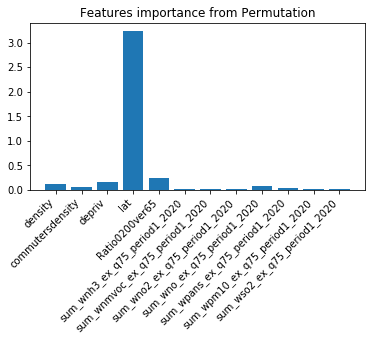

<Figure size 720x720 with 0 Axes>

((0.3438960829398735, 0.02125708473999996),
 (0.9590053517851422, 0.09542998038115931),
 0.3304914308086731,
 {'density': 0.028113508125809383,
  'commutersdensity': 0.01444228605174378,
  'depriv': 0.039827392010061725,
  'lat': 0.8047970107079195,
  'Ratio0200ver65': 0.058486586079099144,
  'sum_wnh3_ex_q75_period1_2020': 0.003194993860647615,
  'sum_wnmvoc_ex_q75_period1_2020': 0.0030898425168659036,
  'sum_wno2_ex_q75_period1_2020': 0.00547762020912077,
  'sum_wno_ex_q75_period1_2020': 0.019945341520424993,
  'sum_wpans_ex_q75_period1_2020': 0.012851917976780886,
  'sum_wpm10_ex_q75_period1_2020': 0.005111226782639017,
  'sum_wso2_ex_q75_period1_2020': 0.004662274158886956})

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38763  0.03130 
    Test set average RMSE:  1.02721  0.11109 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35764
                       R2:  0.94147


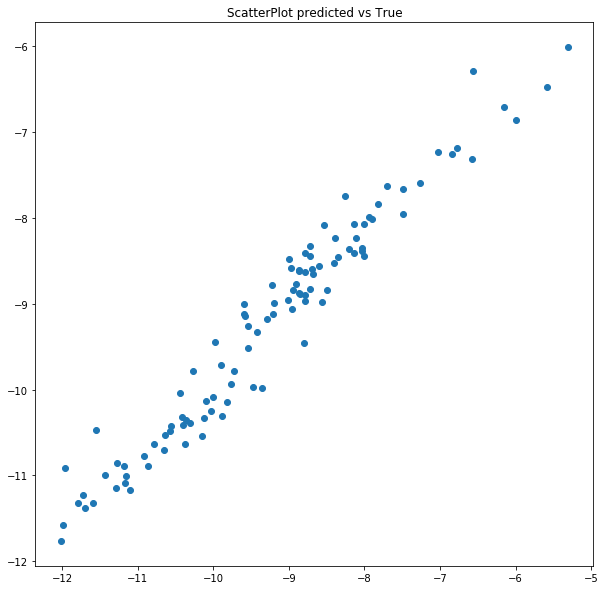

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07968
Feature:               commutersdensity, Score: 0.49409
Feature:                         depriv, Score: 0.07698
Feature:                 Ratio0200ver65, Score: 0.13961
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.03293
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.03346
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.05540
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02103
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02478
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02153
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02050


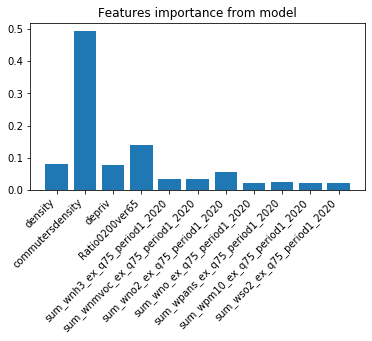

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.15384
Feature:               commutersdensity, Score: 1.79363
Feature:                         depriv, Score: 0.21789
Feature:                 Ratio0200ver65, Score: 0.35614
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.06686
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.05104
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.08435
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05908
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06097
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03673
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03041


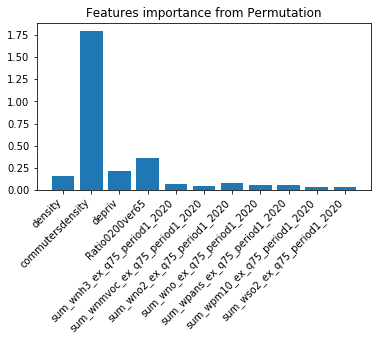

<Figure size 720x720 with 0 Axes>

((0.38763112674193223, 0.03130463180421007),
 (1.0272115836452755, 0.11109433598537304),
 0.3576387814974247,
 {'density': 0.05284974530074697,
  'commutersdensity': 0.6161679115751546,
  'depriv': 0.07485180466733812,
  'Ratio0200ver65': 0.12234469510621665,
  'sum_wnh3_ex_q75_period1_2020': 0.02296900102243531,
  'sum_wnmvoc_ex_q75_period1_2020': 0.01753479847606183,
  'sum_wno2_ex_q75_period1_2020': 0.02897723401273739,
  'sum_wno_ex_q75_period1_2020': 0.020296330955371117,
  'sum_wpans_ex_q75_period1_2020': 0.02094473237872878,
  'sum_wpm10_ex_q75_period1_2020': 0.01261642497992417,
  'sum_wso2_ex_q75_period1_2020': 0.010447321525285101})

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.12790549803096266
2  of  1200 MSE:  0.12422282517560082
3  of  1200 MSE:  0.22930207246393838
4  of  1200 MSE:  0.3234147195908997
5  of  1200 MSE:  0.5165109395001709
6  of  1200 MSE:  0.6449183142922963
7  of  1200 MSE:  0.7600487404476877
8  of  1200 MSE:  0.8180728858446117
9  of  1200 MSE:  0.20291516075545116
10  of  1200 MSE:  0.270618016112294
11  of  1200 MSE:  0.254686674950532
12  of  1200 MSE:  0.35493863823867977
13  of  1200 MSE:  0.5165109395001709
14  of  1200 MSE:  0.6449183142922963
15  of  1200 MSE:  0.7600487404476877
16  of  1200 MSE:  0.8180728858446117
17  of  1200 MSE:  0.3653962971762596
18  of  1200 MSE:  0.46524976408707297
19  of  1200 MSE:  0.40730842033308473
20  of  1200 MSE:  0.5097895636603184
21  of  1200 MSE:  0.5165109395001709
22  of  1200 MSE:  0.6449183142922963
23  of  1200 MSE:  0.7600487404476877
24  of  1200 MSE:  0.8180728858446117
25  of  1200 MSE:  0.5055647946747454
26  of  1200 MSE:  0.5970541426634276
27  of  1200 MSE

Training set average RMSE:  0.36675  0.03075 
    Test set average RMSE:  1.00742  0.12159 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34514
                       R2:  0.94549


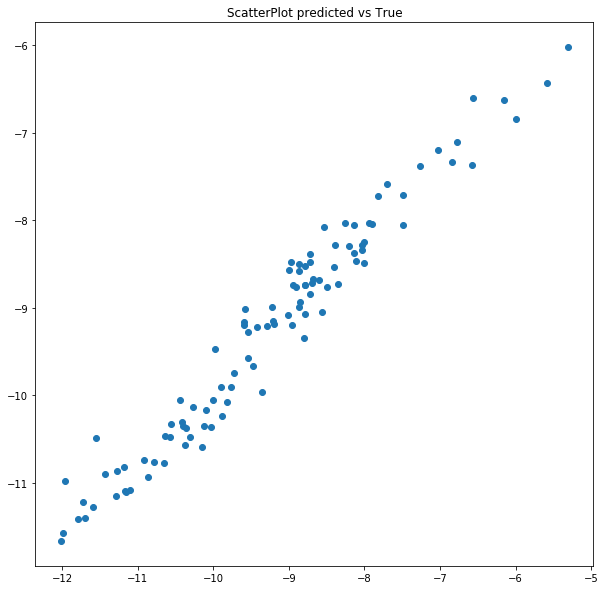

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.08038
Feature:               commutersdensity, Score: 0.23738
Feature:                         depriv, Score: 0.11978
Feature:                 Ratio0200ver65, Score: 0.10297
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.09955
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.10072
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.12205
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01714
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02790
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.06116
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03096


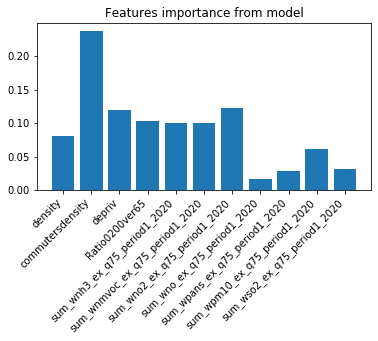

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.15625
Feature:               commutersdensity, Score: 1.83108
Feature:                         depriv, Score: 0.25726
Feature:                 Ratio0200ver65, Score: 0.34519
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.03228
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.04087
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.10576
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05251
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04263
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04231
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04802


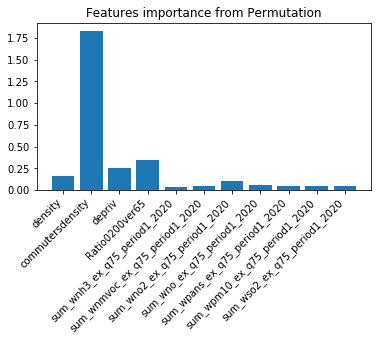

<Figure size 720x720 with 0 Axes>

((0.36674875757093406, 0.03074750964989208),
 (1.0074223424367983, 0.12159237485357037),
 0.3451401216892068,
 {'density': 0.05289193583103233,
  'commutersdensity': 0.619831141972183,
  'depriv': 0.08708425375876956,
  'Ratio0200ver65': 0.11684957994834817,
  'sum_wnh3_ex_q75_period1_2020': 0.010927160501383646,
  'sum_wnmvoc_ex_q75_period1_2020': 0.013834406630081758,
  'sum_wno2_ex_q75_period1_2020': 0.03580131903779401,
  'sum_wno_ex_q75_period1_2020': 0.01777459138754265,
  'sum_wpans_ex_q75_period1_2020': 0.014429404174723647,
  'sum_wpm10_ex_q75_period1_2020': 0.014322731674828832,
  'sum_wso2_ex_q75_period1_2020': 0.016253475083312627})

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.40384  0.02901 
    Test set average RMSE:  1.06758  0.12242 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36802
                       R2:  0.93802


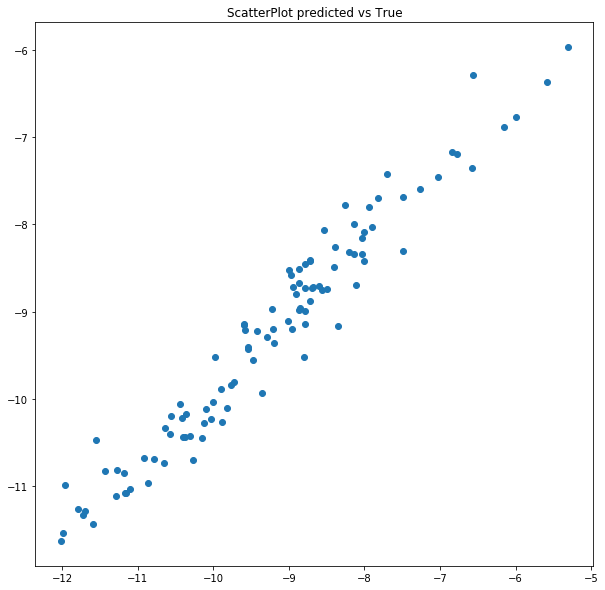

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.10234
Feature:                         depriv, Score: 0.18427
Feature:                 Ratio0200ver65, Score: 0.15277
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.18675
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09177
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.17826
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01778
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02996
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02017
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03593


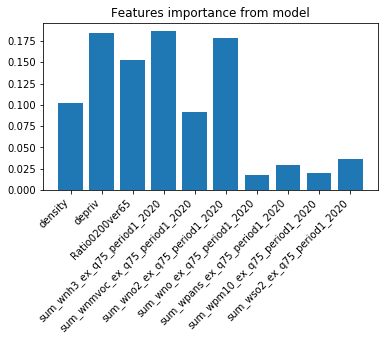

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.22959
Feature:                         depriv, Score: 0.43996
Feature:                 Ratio0200ver65, Score: 0.34556
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.29254
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.15675
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.47372
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05252
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05136
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03081
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.09250


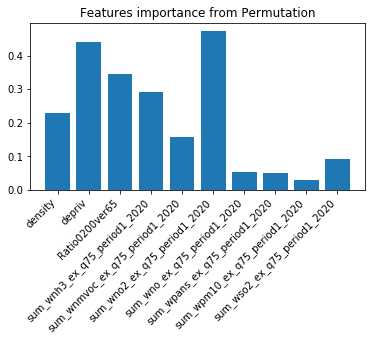

<Figure size 720x720 with 0 Axes>

((0.4038412964405484, 0.029011356416463678),
 (1.0675834440899323, 0.1224164801769228),
 0.3680224631708581,
 {'density': 0.10602957772127397,
  'depriv': 0.20318494459825734,
  'Ratio0200ver65': 0.15958768768750198,
  'sum_wnh3_ex_q75_period1_2020': 0.13510216945120176,
  'sum_wnmvoc_ex_q75_period1_2020': 0.07239038813959553,
  'sum_wno2_ex_q75_period1_2020': 0.2187777327684878,
  'sum_wno_ex_q75_period1_2020': 0.024254355342846073,
  'sum_wpans_ex_q75_period1_2020': 0.023721450918924164,
  'sum_wpm10_ex_q75_period1_2020': 0.014231182633989939,
  'sum_wso2_ex_q75_period1_2020': 0.04272051073792132})

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1354405333983456
2  of  1200 MSE:  0.12764327806001213
3  of  1200 MSE:  0.2523890729879211
4  of  1200 MSE:  0.35332515163786904
5  of  1200 MSE:  0.5767514241250442
6  of  1200 MSE:  0.7068877416928049
7  of  1200 MSE:  0.8226233179970378
8  of  1200 MSE:  0.9044715855299231
9  of  1200 MSE:  0.22582557057251107
10  of  1200 MSE:  0.28478151930087436
11  of  1200 MSE:  0.2817943673751977
12  of  1200 MSE:  0.38714002189606445
13  of  1200 MSE:  0.5767514241250442
14  of  1200 MSE:  0.7068877416928049
15  of  1200 MSE:  0.8226233179970378
16  of  1200 MSE:  0.9044715855299231
17  of  1200 MSE:  0.3890393390321012
18  of  1200 MSE:  0.4902936346130749
19  of  1200 MSE:  0.43245967336658186
20  of  1200 MSE:  0.5537783923108862
21  of  1200 MSE:  0.5767514241250442
22  of  1200 MSE:  0.7068877416928049
23  of  1200 MSE:  0.8226233179970378
24  of  1200 MSE:  0.9044715855299231
25  of  1200 MSE:  0.5331586096502943
26  of  1200 MSE:  0.6493256005396446
27  of  1200 MS

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)